### TODO
* copy in other file
* find unused code
* doublecheck zeropoints
* doublecheck catalogue
* check folder - a temp data folder
* catalogue referencing later is not with variablized
* update planck cosmology

In [2]:
catalogue = "gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits"
cat_out_name = "gds_jwst_nircam_large_withSpec"
# template names and paths

ftempl_labeldict = {#! use ; to indicate modifications
    'fsps_45k;linearcomb': "F45k;LC",
    'fsps_45k;0.3removed': "F45k;0.3r",
    'EMLines;linearcomb': "EMLi;LC",
    'EMextreme': "EMEx",
    'EMlines': "EMLi",
    'fsps_45k': "F45k",
    'fsps_60k': "F60k",
    'carnall_sfhz_13': "CASFH",
    'corr_sfhz_13': "COSFH",
    'blue_sfhz_13': "BLSFH",
    #"EAZL",
    'eazy_v1.3.spectra': "EAZ3",
    #"BR07",
    #"PEG",
    #"PEG13",
    #"CWWK"
}

In [3]:
##################### READ IN TEMPLATES #####################
import os
ftempl_strs = []
ftempl_labels = []
for f in os.listdir("templates2test"):
    if f.endswith(".param"):
        templ_str = f.split(".param")[0]
        ftempl_strs.append(templ_str)
        try:
            ftempl_labels.append(ftempl_labeldict[templ_str])
        except KeyError:
            raise KeyError("No label for template: ", templ_str)
    else: continue
    print("Found template: ", templ_str)
    print("Label: ", ftempl_labeldict[templ_str])
    print("")

Found template:  fsps_45k;0.3removed
Label:  F45k;0.3r

Found template:  corr_sfhz_13
Label:  COSFH

Found template:  fsps_60k
Label:  F60k

Found template:  EMextreme
Label:  EMEx

Found template:  blue_sfhz_13
Label:  BLSFH

Found template:  carnall_sfhz_13
Label:  CASFH

Found template:  eazy_v1.3.spectra
Label:  EAZ3

Found template:  EMlines
Label:  EMLi

Found template:  EMLines;linearcomb
Label:  EMLi;LC

Found template:  fsps_45k
Label:  F45k

Found template:  fsps_45k;linearcomb
Label:  F45k;LC



In [4]:
import eazy
from eazy import filters, utils

#import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np

#import pandas as pd
import time
from math import ceil#, floor
from copy import deepcopy as copy
import shutil
from astropy import units as u
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.table import Table, join#, hstack
#from astropy.visualization import ZScaleInterval as zs
#from astroquery.mast import Observations as obs
#from IPython.utils import io
#from matplotlib.transforms import Affine2D
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import eazy_routines as ez
import helper_module as hmod

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()
    for f in os.listdir("templates2test"):
        shutil.copy("templates2test/"+f, "templates/"+f, follow_symlinks=True, exist_ok=True)


cosmo = Planck18
del Planck18

plt.style.use('seaborn-v0_8-colorblind')

if "temp" not in os.listdir():
    os.mkdir("temp")

In [10]:
# log all camera filters
flt = eazy.filters.FilterFile()

filts_nircam = {
    'F090W': 363,
    'F115W': 364,
    'F150W': 365,
    'F182M': 370,
    'F200W': 366,
    'F210M': 371,
    'F277W': 375,
    'F335M': 381,
    'F356W': 376,
    'F410M': 383,
    'F430M': 384,
    'F444W': 358,
    'F460M': 385,
    'F480M': 386
}

filts_HST = {
    'F105W': 202,
    'F125W': 203,
    'F140W': 204,
    'F160W': 205,
    'F435W': 233,
    'F606W': 214,
    'F775W': 216,
    'F814W': 239,
    'F850LP': 240        
}

filts_wavelengths = {#!actually check
}
res = filters.FilterFile('FILTER.RES.latest')
for f in res.filters:
    for filt in filts_nircam | filts_HST:
        if filt.lower() in f.name:
            filts_wavelengths[filt] = {
                'mean': f.pivot,
                'width': f.rectwidth
                }
            break

filts = {**filts_nircam, **filts_HST}
del filts_HST, filts_nircam

mw_reddening = ez.get_atten_dict(filts)#!is used?

# get zeropoints
zps = [1.0]*len(filts)#!should be evaluated if this is correct

In [11]:
#=== load data
#inname = "hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
inname = catalogue.split('/')[-1]
inpath = os.path.join(os.getenv('astrodata'), catalogue)

# print the meta info
with fits.open(inpath) as hdul:
    print(hdul.info())

# load photometry table
tab = Table.read(inpath, hdu=6)
tab_redshifts = Table.read(inpath, hdu=9)

#=== make EAZY table

# load fluxes
# CIRC1: 0.10 arcsec aperture (see README)
ext = '_CIRC1'
cols_dummy = hmod.get_matches(ext, tab.columns, exclude='_ei')
cols_f = np.sort(hmod.get_matches(ext, cols_dummy, exclude='_e'))
cols_fe = np.sort(hmod.get_matches('_e', cols_dummy))
cols_fluxes = list(np.vstack([cols_f, cols_fe]).T.flatten())
cols = list(np.insert(cols_fluxes, 0, ['ID', 'RA', 'DEC', 'z_spec']))
del cols_dummy

tab = join(tab, tab_redshifts['ID', 'z_spec'], join_type='inner', keys='ID')
tab_out = tab[cols]

# convert from nJy to uJy
# and apply MW reddening
keys = np.array(list(mw_reddening.keys()))
for c in cols_fluxes:
    tab_out[c].unit = u.nJy
    tab_out[c] = tab_out[c].to(u.uJy)
    
    # apply MW reddening
    matches = hmod.get_matches(keys, c, get_idxs=True)
    key = keys[np.int32(matches[:,0])][0]
    tab_out[c] *= mw_reddening[key]
del c, keys, key, matches
    
# rename columns
for c in cols_f:
    cnew = c.replace(ext, '_flux')
    tab_out.rename_column(c, cnew)
del c, cnew

for c in cols_fe:
    cnew = c.replace(ext+'_e', '_err')
    tab_out.rename_column(c, cnew)
del c, cnew

#=== apply MW reddening
#atten_dict = ez.get_atten_dict(filts_eazyres, filts_str)
#degr_image_sig *= atten_dict[filt] / 100. # uJy

# save EAZY table
tab_out.write(f'temp/{cat_out_name}.fits', format='fits', overwrite=True)
del tab_out, tab, tab_redshifts

Filename: /home/ubuntu-compute/Desktop/astrodata/gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   1429R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   1429R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   1429R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

In [12]:
runTime = int(time.time())

In [13]:
#=== set up paths for eazy

# catalog paths
cat_path = f'temp/{cat_out_name}.fits'
keys_id = ['ID id', 'RA ra', 'DEC dec', 'z_spec z_spec']



templ_paths = [f"templates/{e}.param" for e in ftempl_strs]
out_names = [f for f in ftempl_strs]
out_paths = [f"eazy-output/{f}_{runTime}" for f in out_names]
#paths = np.array([templ_paths, out_paths]).T

In [39]:
##################### RUN EAZY #####################

# iterate over tempalte sets
photZs = []
for tpath, opath, oname in zip(templ_paths, out_paths, out_names):
    
    params = {"cat_path": cat_path,
              "templ_path": tpath,
              "out_path": opath,
              "FIX_ZSPEC": 'n',
              "USE_ZSPEC_FOR_REST": 'n',
              "Z_MAX": 12.0,
              "H0": cosmo.H0,
              "OMEGA_M": cosmo.Om0,
              "OMEGA_L": cosmo.Ode0,
              "CATALOG_FORMAT": 'fits'}
    
    # write eazy config files
    filt_num, fnames = ez.write_config(f'{cat_out_name}_{oname}', filts, zps, keys_id,
                                       out_path=opath)

    # run eazy
    #idx = np.array([0])
    idx = None
    #zout, hdu = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)
    from eazy import photoz
    #from eazy import templates
    #from eazy import filters
    #from eazy import utils
    #photZ = photoz.PhotoZ(param_file=tpath, translate_file='gds_jades_eazy.zphot.translate', zeropoint_file=None,
    #                        params=params)
    #photZ.fit_parallel(n_proc=-1, idx=idx)
    zout, __ = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)
    photZs.append(zout)
    del idx, params, filt_num, fnames, tpath, opath, oname

Read default param file: /home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: temp/gds_jwst_nircam_large_withSpec.fits
   >>> NOBJ = 1429
F090W_flux F090W_err (363): jwst_nircam_f090w
F115W_flux F115W_err (364): jwst_nircam_f115w
F150W_flux F150W_err (365): jwst_nircam_f150w
F182M_flux F182M_err (370): jwst_nircam_f182m
F200W_flux F200W_err (366): jwst_nircam_f200w
F210M_flux F210M_err (371): jwst_nircam_f210m
F277W_flux F277W_err (375): jwst_nircam_f277w
F335M_flux F335M_err (381): jwst_nircam_f335m
F356W_flux F356W_err (376): jwst_nircam_f356w
F410M_flux F410M_err (383): jwst_nircam_f410m
F430M_flux F430M_err (384): jwst_nircam_f430m
F444W_flux F444W_err (358): jwst_niriss_f444w
F460M_flux F460M_err (385): jwst_nircam_f460m
F480M_flux F480M_err (386): jwst_nircam_f480m
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat


/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/photoz.py:1326: RuntimeWarning: invalid value encountered in log10
  self.prior_mag_cat += -2.5*np.log10(np.squeeze(self.fnu[:,ix]))
100%|██████████| 4/4 [00:59<00:00, 14.86s/it]


Template   0: fsps_45k_t0.1_Av0.0.fits (NZ=1).
Template   1: fsps_45k_t0.1_Av0.5.fits (NZ=1).
Template   2: fsps_45k_t0.5_Av0.0.fits (NZ=1).
Template   3: fsps_45k_t0.5_Av0.5.fits (NZ=1).
Process templates: 60.137 s


256it [00:00, 2749.83it/s]
100%|██████████| 256/256 [00:04<00:00, 63.05it/s]


Compute best fits
fit_best: 0.2 s (n_proc=1,  NOBJ=1415)
Fit 4.5 s (n_proc=19, NOBJ=1429)
Get best fit coeffs & best redshifts
fit_best: 0.7 s (n_proc=1,  NOBJ=1415)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/photoz.py:3846: RuntimeWarning: overflow encountered in exp
  pzcum = cumtrapz(np.exp(spl(zgrid_zoom)), x=zgrid_zoom, axis=1)
100%|██████████| 1415/1415 [00:06<00:00, 204.01it/s]
/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/photoz.py:4111: RuntimeWarning: invalid value encountered in divide
  coeffs_norm = (coeffs_norm.T/coeffs_norm.sum(axis=1)).T
/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/photoz.py:4146: RuntimeWarning: invalid value encountered in divide
  draws_norm = (draws_norm.T/draws_norm.sum(axis=2).T).T



 Couldn't find template parameters file templates/fsps_45k;0.3removed.param.fits for population synthesis 
 calculations.
            


100%|██████████| 1415/1415 [00:20<00:00, 69.41it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 1415/1415 [00:05<00:00, 277.29it/s]
/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/photoz.py:3960: RuntimeWarning: divide by zero encountered in log10
  obsm = self.param.params['PRIOR_ABZP'] - 2.5*np.log10(rf[:,i,:])
/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/photoz.py:3960: RuntimeWarning: invalid value encountered in log10
  obsm = self.param.params['PRIOR_ABZP'] - 2.5*np.log10(rf[:,i,:])


Read default param file: /home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: temp/gds_jwst_nircam_large_withSpec.fits
   >>> NOBJ = 1429
F090W_flux F090W_err (363): jwst_nircam_f090w
F115W_flux F115W_err (364): jwst_nircam_f115w
F150W_flux F150W_err (365): jwst_nircam_f150w
F182M_flux F182M_err (370): jwst_nircam_f182m
F200W_flux F200W_err (366): jwst_nircam_f200w
F210M_flux F210M_err (371): jwst_nircam_f210m
F277W_flux F277W_err (375): jwst_nircam_f277w
F335M_flux F335M_err (381): jwst_nircam_f335m
F356W_flux F356W_err (376): jwst_nircam_f356w
F410M_flux F410M_err (383): jwst_nircam_f410m
F430M_flux F430M_err (384): jwst_nircam_f430m
F444W_flux F444W_err (358): jwst_niriss_f444w
F460M_flux F460M_err (385): jwst_nircam_f460m
F480M_flux F480M_err (386): jwst_nircam_f480m
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat


  0%|          | 0/13 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [15]:
#find latest runTime in folder:
runtimeNum = -2
runTimes = np.sort([int(f.split('_')[-1]) for f in os.listdir('eazy-output') if f != '.gitignore'])
runTimes = np.unique(runTimes)
runTime = int(runTimes[runtimeNum])
outpaths = 'eazy-output/{ftempl}_{runTime}/' + cat_out_name + '.zout.fits'
print("Picking runTime:", runTime)
del runTimes, runtimeNum

Picking runTime: 1696803274


In [16]:
##################### READ EAZY OUTPUT #####################
rawSets = {}
for ftempl in ftempl_strs:
    outpath = outpaths.format(ftempl=ftempl, runTime=runTime)
    if f'{ftempl}_{runTime}' not in os.listdir('eazy-output'):
        continue
    if cat_out_name + '.zout.fits' not in os.listdir(outpath.rsplit('/', 1)[0]):
        continue
    rawSets[ftempl] = Table.read(outpath)
del ftempl, outpath

In [17]:
##################### READ REDSHIFT OUTPUT #####################
redshiftSets = {}
for key in rawSets.keys():
    tbl = rawSets[key]
    data = {}
    data['ID'] = tbl['id']
    data['z_spec'] = tbl['z_spec']
    data['z_phot'] = tbl['z_phot']
    data['z_phot_chi2'] = tbl['z_phot_chi2']
    data['z_phot_risk'] = tbl['z_phot_risk']
    redshiftSets[key] = Table(
        data = [d for d in data.values()],
        names = [d for d in data.keys()]
    )
del key, tbl, data

In [18]:
##################### PHOTOMETRY DATA #####################
#copy photometry data to every template set (for convenience)
photSets = {}
for key in rawSets.keys():
    tbl = rawSets[key]
    data = {}
    data['ID'] = tbl['id']
    data['chi2'] = tbl['z_phot_chi2']
    for tblkey in tbl.keys():
        if tblkey.startswith('rest'):
            data[tblkey] = tbl[tblkey]
    #for each object, check if the photometry is valid
    #if not, remove
    for i in list(range(len(data['ID'])))[::-1]:
        dataValid = True
        restPhotVals = []
        for p in data.keys():
            if "rest" not in p: continue
            if data[p][i] < 0: dataValid = False
            if "err" not in p: restPhotVals.append(data[p][i])
        if np.sum(restPhotVals) == 0: dataValid = False
        if not dataValid:
            for p in data.keys(): data[p] = np.delete(data[p], i)
    #convert to table
    photSets[key] = Table(
        data = [d for d in data.values()],
        names = [d for d in data.keys()]
    )
del key, tbl, data, tblkey


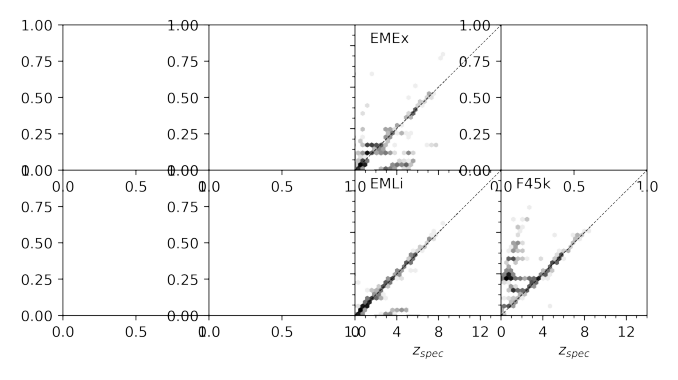

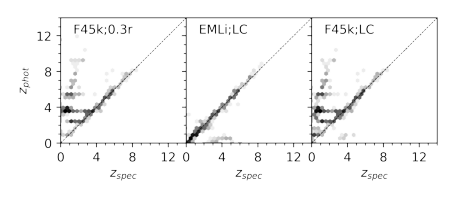

In [19]:
##################### PLOT REDSHIFT OUTPUT #####################
#TODO: needs tiling color by accumulative flux
mosTiling = 4
zMax = 14
mm = 1/25.4
figwidth = 183*mm
DPI = 500

for mode in ['default', 'modified']:
    mode_ftempl_lbls = copy(ftempl_labels)
    mode_ftempl_strs = copy(ftempl_strs)
    if mode == 'modified': 
        mode_ftempl_lbls = [s for s in mode_ftempl_lbls if ";" in s]
        mode_ftempl_strs = [s for s in mode_ftempl_strs if ";" in s]
    if mode == 'default': 
        mode_ftempl_lbls = [s for s in mode_ftempl_lbls if ";" not in s]
        mode_ftempl_strs = [s for s in mode_ftempl_strs if ";" not in s]

    
    mosaicLen = ceil(len(mode_ftempl_lbls)/mosTiling)
    
    figsize = (1*figwidth,1*figwidth/mosTiling*mosaicLen)
    tiling = (mosaicLen,mosTiling)
    if len(mode_ftempl_lbls) < mosTiling:
        figsize = (1*figwidth/mosTiling*len(mode_ftempl_lbls),1*figwidth/mosTiling)
        tiling = (1,len(mode_ftempl_lbls))

    figMos, axsMos = plt.subplots(*tiling, figsize=figsize, dpi=DPI, facecolor=(1,1,1,0))
    #transpose and flatten
    if len(mode_ftempl_lbls) > 1:
        #axsMos = axsMos.T
        axsMos = axsMos.flatten()
    else:
        axsMos = [axsMos]
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ftempl in enumerate(mode_ftempl_strs):
        if ftempl not in redshiftSets.keys():
            continue
        redshiftTbl = redshiftSets[ftempl]

        #outpath = outpaths.format(ftempl=ftempl, runTime=runTime)

        """#find light intensities
        ids = df_props['id'].values
        filtTab = Table.read(inpath, hdu=4)
        #get values ending with "CIRC1"
        pointIDs = filtTab['ID']
        filtTab = filtTab[[f for f in filtTab.colnames if f.endswith('CIRC1')]]
        #get dictionary version of table
        filtTab = filtTab.to_pandas()
        keys = filtTab.keys()
        fluxes = np.array([np.array(filtTab[key]) for key in keys]).T
        pointIntensities = np.sum(fluxes, axis=1)"""

        """#clear up bad ids and make simular sort
        for j,id in list(enumerate(ids))[::-1]:
            if id not in df_props['id'].values:
                pointIntensities = np.delete(pointIntensities, j)
                ids = np.delete(ids, j)
        #sort pointIntensities and ids to match df_props
        pointIntensities = pointIntensities[np.argsort(ids)]
        ids = np.sort(ids)
        antiSort = np.argsort(df_props['id'].values)
        sort = np.argsort(antiSort)
        pointIntensities = pointIntensities[sort]
        ids = ids[sort]"""
        #Remove sub zero and nan
        mask_cur = (redshiftTbl['z_spec'] > 0) & (~np.isnan(redshiftTbl['z_spec'])) & (~np.isnan(redshiftTbl['z_phot']))
        x = np.array(redshiftTbl['z_spec'])
        y = np.array(redshiftTbl['z_phot'])
        #above = y > x + (1 + x) * 0.15 # outliers
        #below = y < x - (1 + x) * 0.15
        #outlier = above | below
        #mask_in = mask_cur & (~outlier)
        x = x[mask_cur]
        y = y[mask_cur]
        #mask_out = mask_cur & outlier
        #chi2_fit = redshiftTbl['z_phot_chi2'][mask_cur]/len(redshiftTbl.keys())#!new
        #avgchi2_fit = np.mean(chi2_fit)
        #medchi2_fit = np.median(chi2_fit)
        
        #avgchi2_fit_in = redshiftTbl['z_phot_chi2'][mask_in]/len(x)#!new
        #c = np.log10(pointIntensities[mask_cur])*((x/(1+x))**2)#!quilitative reshift scaling
        #c = np.ones(len(x))

        #calculate chi2 with linear regression of x and y
        chi2 = np.sum((y - x)**2/1)/len(x)#/len(x)#!dunno what to put for sigma

        xmin, xmax = np.c_[[x, y]].min(), np.c_[[x, y]].max()

        #axsMos[i].scatter(x, y, s=2.0, color='k')
        #hexbin with colorbar
        axsMos[i].hexbin(x, y, gridsize=30, cmap='Greys', mincnt=1, edgecolors='none', bins='log')
        #plt.colorbar(axsMos[i].collections[0], ax=axsMos[i], label='log$_{10}$(N)')
        axsMos[i].plot([0, 100], [0, 100], c='k', ls='--', lw=0.5)
        
        #dict_stat = hmod.phot_spec_zs_stats(y, x)

        #annotate in top left
        annotAnchor = (0.05, 0.95)
        #axsMos[i].set_title(f'{ftempl}', fontsize=10)
        ax, ay = 10, 95        
        axsMos[i].annotate(f'{mode_ftempl_lbls[i]}', xy=annotAnchor, xycoords='axes fraction', fontsize=10, ha='left', va='top', xytext=(ax, ay), textcoords='axes points')


        axsMos[i].set_xlim(0,zMax)
        axsMos[i].set_ylim(0,zMax)

        axsMos[i].xaxis.set_minor_locator(MultipleLocator(1))
        axsMos[i].yaxis.set_minor_locator(MultipleLocator(1))
        axsMos[i].xaxis.set_major_locator(MultipleLocator(4))
        axsMos[i].yaxis.set_major_locator(MultipleLocator(4))

        if i % mosTiling != 0: axsMos[i].set_yticklabels([])
        else: axsMos[i].set_ylabel('$z_{phot}$', fontsize=10)
        if i < len(mode_ftempl_lbls)-mosTiling: axsMos[i].set_xticklabels([])
        else: axsMos[i].set_xlabel('$z_{spec}$', fontsize=10)

    for i in range(len(axsMos)):
        if i > len(mode_ftempl_lbls)-1:
            axsMos[i].axis('off')

    """if len(ftempl_strs) % 3 != 0:
        axsMos[-1].axis('off')
    if len(ftempl_strs) % 3 == 1:
        axsMos[-2].axis('off')"""

    #axis label
    #figMos.text(0.5, 0.05, '$z_{spec}$', ha='center', va='center')
    #figMos.text(0.05, 0.5, '$z_{phot}$', ha='center', va='center', rotation='vertical')

    figMos.savefig(f'./figures/zs_mosaic_{mode}.png', dpi=DPI, bbox_inches='tight', transparent=True)
    figMos.clf()
    plt.close(figMos)
    #show by loading image
    img = plt.imread(f'./figures/zs_mosaic_{mode}.png')
    fig = plt.figure(figsize=(1*figwidth,1*figwidth/mosTiling*mosaicLen), dpi=100, facecolor=(1,1,1,0))
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)


In [20]:
##################### REDSHIFT PERFORMANCE METRICS #####################
#TODO: create a pandas dataframe over bias, scatter, so on
#TODO: both print it out here and make a latex table for the paper

In [ ]:
##################### PLOT RESTFRAME SEDS ##################### DOES NOT WORK SINCE THERE IS NO TRANSLATION FROM ZOUT FILTER VALUES TO WAVELENGTHS :(
#! WIP
#take the 10 worst chi2 and 10 best chi2
#for now, just plot restframe photometry
for key in photSets.keys():
    tbl = photSets[key]
    chi2s = tbl['chi2']
    sort = list(np.argsort(chi2s))
    include = [0,len(sort)//2,-1]
    sort = np.array(sort)[include]
    del include

    phot_vals = np.array([np.array(tbl[key]) for key in tbl.keys() if key.startswith('rest') and "err" not in key])
    phot_errs = np.array([np.array(tbl[key]) for key in tbl.keys() if key.startswith('rest') and key.endswith('err')])
    filterNums = np.array([int(key.split('rest')[-1]) for key in tbl.keys() if key.startswith('rest') and "err" not in key and 'U' not in key and 'B' not in key and 'V' not in key and 'J' not in key])
    #get filter names
    filterNames = []
    for filt in filterNums:
        for fkey in filts.keys():
            if filts[fkey] == filt:
                filterNames.append(fkey)
                break

    chi2s = chi2s[sort]
    phot_vals = phot_vals.T[sort]
    phot_errs = phot_errs.T[sort]

    #plot
    fig, axs = plt.subplots(len(sort),1,figsize=(5,4), dpi=200, facecolor=(1,1,1,0))
    #set title
    axs[0].set_title(rf'{key} - best,middle,worst $\chi^2$')
    for i in range(len(sort)):
        ax = axs[i]
        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xlabel('Wavelength [micron]')
        ax.set_ylabel('Flux [uJy]')#! doublecheck
        
        ax.grid(True, which='both', alpha=0.5)#!todo actually find the proper wavelengths for the filters
        wave = np.array([filts_wavelengths[filt]['mean'] for filt in filterNames])
        print(wave)
        ax.errorbar(wave,phot_vals[i], phot_errs[i], ls='', marker='.', ms=2.0, color='k', alpha=0.5)
    fig.savefig(f'./figures/spectra/phot_{key}_{i}.png', dpi=DPI, bbox_inches='tight', transparent=True)
    fig.show()
    plt.show()
    plt.close(fig)

    
